In [0]:
from sklearn.datasets import load_diabetes
from pyspark.sql import SparkSession
import numpy as np
import pandas as pd
from pyspark.sql.functions import *
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

# load
dataX, dataY = load_diabetes(return_X_y=True, as_frame=True)
dataY = dataY.to_frame()

# create Spark DataFrame
spark = SparkSession \
    .builder \
    .appName("Python Spark regression example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

sparkX = spark.createDataFrame(dataX)
sparkY = spark.createDataFrame(dataY)

sparkX = sparkX.withColumn("id", monotonically_increasing_id())
sparkY = sparkY.withColumn("id", monotonically_increasing_id())
data = sparkY.join(sparkX, "id", "left")
data = data.select(col("age").alias("age"), col("target").alias("label"))
# data.show(5)

# Convert the data to dense vector (features and label)
def transData(data):
    return data.rdd.map(lambda r: [Vectors.dense(r[:-1]),r[-1]]).toDF(['features','label'])
 
transformed= transData(data)
# transformed.show(5)

# Automatically identify categorical features, and index them.
featureIndexer = VectorIndexer(inputCol="features", \
                               outputCol="indexedFeatures",\
                               maxCategories=4).fit(transformed)
 
data = featureIndexer.transform(transformed)
# data.show(5,True)


# 6. Split the data into training and test sets (40% held out for testing)
(trainingData, testData) = transformed.randomSplit([0.7, 0.3])
# trainingData.show(5)
# testData.show(5)

# 7. Fit Ordinary Least Square Regression Model
 
from pyspark.ml.regression import LinearRegression
 
# Define LinearRegression algorithm
lr = LinearRegression()
 
# 8. Pipeline Architecture
# Chain indexer and tree in a Pipeline
pipeline = Pipeline(stages=[featureIndexer, lr])
 
model = pipeline.fit(trainingData)
 
    
# 9. summary of the Model
def modelsummary(model):
    import numpy as np
    print ("Note: the last rows are the information for Intercept")
    print ("##","-------------------------------------------------")
    print ("##","  Estimate   |   Std.Error | t Values  |  P-value")
    coef = np.append(list(model.coefficients), model.intercept)
    Summary=model.summary
 
    for i in range(len(Summary.pValues)):
        print ("##",'{:10.6f}'.format(coef[i]),\
        '{:10.6f}'.format(Summary.coefficientStandardErrors[i]),\
        '{:8.3f}'.format(Summary.tValues[i]),\
        '{:10.6f}'.format(Summary.pValues[i]))
 
    print ("##",'---')
    print ("##","Mean squared error: % .6f" \
           % Summary.meanSquaredError, ", RMSE: % .6f" \
           % Summary.rootMeanSquaredError )
    print ("##","Multiple R-squared: %f" % Summary.r2, ", \
            Total iterations: %i"% Summary.totalIterations)
    print("Coefficients", model.coefficients)
 
modelsummary(model.stages[-1])

# 10. Make predictions
predictions = model.transform(testData)
 
# Select example rows to display.
# predictions.show(5)

# 9. Evaluation
from pyspark.ml.evaluation import RegressionEvaluator
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(labelCol="label",
                                predictionCol="prediction",
                                metricName="rmse")
 
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
 
y_true = predictions.select("label").toPandas()
y_pred = predictions.select("prediction").toPandas()
features = predictions.select("features")
 
import sklearn.metrics
r2_score = sklearn.metrics.r2_score(y_true, y_pred)
print('r2_score: {0}'.format(r2_score))

Note: the last rows are the information for Intercept
## -------------------------------------------------
##   Estimate   |   Std.Error | t Values  |  P-value
## 296.228741  93.014066    3.185   0.001595
## 152.573389   4.256282   35.847   0.000000
## ---
## Mean squared error:  5640.554949 , RMSE:  75.103628
## Multiple R-squared: 0.031485 ,             Total iterations: 0
Coefficients [296.2287405943137]
Root Mean Squared Error (RMSE) on test data = 76.9281
r2_score: 0.04246711838156514


/databricks/spark/python/pyspark/sql/pandas/conversion.py:92: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)


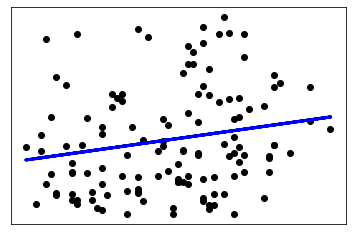

In [0]:
import matplotlib.pyplot as plt

# features.info()
features = predictions.select("features").toPandas()
features["feature"] = features["features"].astype('string').str[1:-1].astype('float')

# # Plot outputs
plt.scatter(features["feature"], y_true, color="black")
plt.plot(features["feature"], y_pred, color="blue", linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [0]:
from sklearn.datasets import load_diabetes
from pyspark.sql import SparkSession
import numpy as np
import pandas as pd
from pyspark.sql.functions import *
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

# load
dataX, dataY = load_diabetes(return_X_y=True, as_frame=True)
dataY = dataY.to_frame()

# create Spark DataFrame
spark = SparkSession \
    .builder \
    .appName("Python Spark regression example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

sparkX = spark.createDataFrame(dataX)
sparkY = spark.createDataFrame(dataY)

sparkX = sparkX.withColumn("id", monotonically_increasing_id())
sparkY = sparkY.withColumn("id", monotonically_increasing_id())
data = sparkY.join(sparkX, "id", "left")
data = data.drop("id")
# data.show(5)

# Convert the data to dense vector (features and label)
def transData(data):
    return data.rdd.map(lambda r: [Vectors.dense(r[1:-1]),r[0]]).toDF(['features','label'])
 
transformed= transData(data)
# transformed.show(5)

# Automatically identify categorical features, and index them.
featureIndexer = VectorIndexer(inputCol="features", \
                               outputCol="indexedFeatures",\
                               maxCategories=4).fit(transformed)
 
data = featureIndexer.transform(transformed)
# data.show(5,True)


# 6. Split the data into training and test sets (40% held out for testing)
(trainingData, testData) = transformed.randomSplit([0.7, 0.3])
# trainingData.show(5)
# testData.show(5)

# 7. Fit Ordinary Least Square Regression Model
 
from pyspark.ml.regression import LinearRegression
 
# Define LinearRegression algorithm
lr = LinearRegression()
 
# 8. Pipeline Architecture
# Chain indexer and tree in a Pipeline
pipeline = Pipeline(stages=[featureIndexer, lr])
 
model = pipeline.fit(trainingData)
 
    
# 9. summary of the Model
def modelsummary(model):
    import numpy as np
    print ("Note: the last rows are the information for Intercept")
    print ("##","-------------------------------------------------")
    print ("##","  Estimate   |   Std.Error | t Values  |  P-value")
    coef = np.append(list(model.coefficients), model.intercept)
    Summary=model.summary
 
    for i in range(len(Summary.pValues)):
        print ("##",'{:10.6f}'.format(coef[i]),\
        '{:10.6f}'.format(Summary.coefficientStandardErrors[i]),\
        '{:8.3f}'.format(Summary.tValues[i]),\
        '{:10.6f}'.format(Summary.pValues[i]))
 
    print ("##",'---')
    print ("##","Mean squared error: % .6f" \
           % Summary.meanSquaredError, ", RMSE: % .6f" \
           % Summary.rootMeanSquaredError )
    print ("##","Multiple R-squared: %f" % Summary.r2, ", \
            Total iterations: %i"% Summary.totalIterations)
    print("Coefficients", model.coefficients)
 
modelsummary(model.stages[-1])

# 10. Make predictions
predictions = model.transform(testData)
 
# Select example rows to display.
# predictions.show(5)

# 9. Evaluation
from pyspark.ml.evaluation import RegressionEvaluator
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(labelCol="label",
                                predictionCol="prediction",
                                metricName="rmse")
 
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
 
y_true = predictions.select("label").toPandas()
y_pred = predictions.select("prediction").toPandas()
features = predictions.select("features")
 
import sklearn.metrics
r2_score = sklearn.metrics.r2_score(y_true, y_pred)
print('r2_score: {0}'.format(r2_score))

Note: the last rows are the information for Intercept
## -------------------------------------------------
##   Estimate   |   Std.Error | t Values  |  P-value
##  30.731865  71.987440    0.427   0.669786
## -190.631622  76.275229   -2.499   0.013035
## 450.588112  82.505715    5.461   0.000000
## 308.957950  78.541127    3.934   0.000106
## -869.499520 513.176857   -1.694   0.091344
## 535.248409 405.885572    1.319   0.188373
## 173.846056 271.561540    0.640   0.522600
## 188.703444 207.218325    0.911   0.363286
## 840.529674 208.464029    4.032   0.000072
## 149.104388   3.276091   45.513   0.000000
## ---
## Mean squared error:  2901.685753 , RMSE:  53.867298
## Multiple R-squared: 0.483322 ,             Total iterations: 0
Coefficients [30.731864694787372,-190.63162221236175,450.5881119345274,308.95795009346926,-869.4995196030583,535.2484089068207,173.84605622500686,188.7034443893824,840.5296740461864]
Root Mean Squared Error (RMSE) on test data = 53.8009
r2_score: 0.55219258091